<a href="https://colab.research.google.com/github/adeebiscoding/tenserflow/blob/main/Copy_of_sport_prediction_myown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##loading kaggle

In [ ]:
!pip install -q kaggle

In [2]:
# from google.colab import files
# files.upload()
#Upload your username and pwd here

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gpiosenka/sports-classification

 99% 473M/477M [00:03<00:00, 152MB/s]
100% 477M/477M [00:03<00:00, 139MB/s]


In [ ]:
!unzip /content/sports-classification.zip

In [ ]:
train_dir = "/content/train"
test_dir = "/content/test"
valid_dir = "/content/valid"

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

--2022-09-25 16:17:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-25 16:17:40 (107 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



##Processing data

In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 13572 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [ ]:
class_names = train_data.class_names

##Creating model

###Callbacks

In [ ]:
checkpoint_path="myOwn_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)



###Model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential 

data_aug_layer = Sequential([
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1, required for models like ResNet50
], name="data_augmentation")

In [ ]:
base_model = tf.keras.applications.EfficientNetB3(include_top = False)
base_model.trainable = False

inputs = layers.Input(shape = (224,224,3)) #reshapeing inputs
x = data_aug_layer(inputs) # augmenting inputs
x = base_model(x, training = False) # passing augmented data to base model
x = layers.GlobalAveragePooling2D(name = "global_avg_2d")(x) #passing x to this layer to get important things from data only
outputs = layers.Dense(len(class_names), activation = "softmax", name = "output_layer")(x)
model_0 = tf.keras.Model(inputs,outputs)


In [ ]:
model_0.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

history_initial = model_0.fit(train_data,
                              epochs = 20,
                              validation_data = valid_data,
                              validation_steps = (0.1 * len(valid_data)),
                              callbacks = [checkpoint_callback, early_stop_callback ])

Epoch 1/20
425/425 [==============================] - 47s 92ms/step - loss: 2.0707 - accuracy: 0.5521 - val_loss: 0.6828 - val_accuracy: 0.8281
Epoch 2/20
425/425 [==============================] - 37s 88ms/step - loss: 0.9972 - accuracy: 0.7569 - val_loss: 0.4645 - val_accuracy: 0.8594
Epoch 3/20
425/425 [==============================] - 37s 87ms/step - loss: 0.7783 - accuracy: 0.8005 - val_loss: 0.4161 - val_accuracy: 0.8594
Epoch 4/20
425/425 [==============================] - 37s 88ms/step - loss: 0.6571 - accuracy: 0.8274 - val_loss: 0.3103 - val_accuracy: 0.9062
Epoch 5/20
425/425 [==============================] - 37s 87ms/step - loss: 0.5841 - accuracy: 0.8464 - val_loss: 0.3582 - val_accuracy: 0.8906
Epoch 6/20
425/425 [==============================] - 37s 87ms/step - loss: 0.5255 - accuracy: 0.8584 - val_loss: 0.3063 - val_accuracy: 0.9062
Epoch 7/20
425/425 [==============================] - 37s 87ms/step - loss: 0.5039 - accuracy: 0.8635 - val_loss: 0.4065 - val_accuracy:

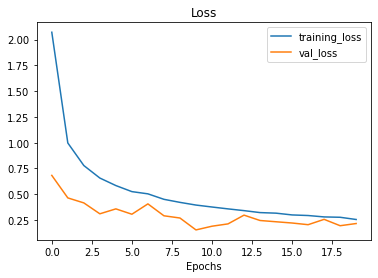

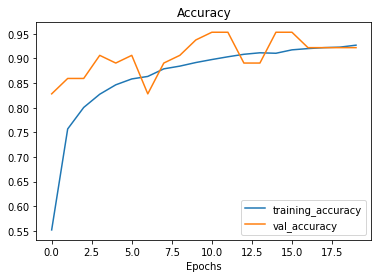

In [ ]:
plot_loss_curves(history_initial)

In [ ]:
#evaluating model
model_0.evaluate(test_data)

16/16 [==============================] - 2s 83ms/step - loss: 0.2037 - accuracy: 0.9360


[0.2036728858947754, 0.9359999895095825]

In [ ]:
#train model for another 30 epochs with callbacks

history_initial_additonal_30 = model_0.fit(train_data,
                              epochs = 50,
                              initial_epoch = history_initial.epoch[-1],
                              validation_data = valid_data,
                              validation_steps = (0.1 * len(valid_data)),
                              callbacks = [checkpoint_callback, early_stop_callback ])

##Random things
(future me: i dont need to see this section)

In [ ]:
model_0.load_weights(checkpoint_path) # to load data from checkpoint

##Fine Tuning

If we dont like our fine tune, we can revert back to old model using `model_0.load_weights(checkpoint_path)`

In [ ]:
for layer in base_model.layers:
  print(layer.name, layer.trainable)

#the more lower the layer is in this list, the close it is to the output

In [ ]:
base_model.trainable = True #unfreezing ALL layers

#Refreezinf all layers except the 8 ones closest to output
for layer in base_model.layers[:-8]:
  layer.trainable = False


In [ ]:

#compile with lower learning rate since we want model to keep some weights
model_0.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

history_fine_tuned = model_0.fit(train_data,
                                 epochs = 70,
                                 validation_data = valid_data,
                                 validation_steps = int(0.5 * len(valid_data)),
                                 initial_epoch = history_initial_additonal_30.epoch[-1],
                                  verbose = 1,
                                 callbacks = [early_stop_callback])

Epoch 44/70
425/425 [==============================] - 51s 97ms/step - loss: 0.1499 - accuracy: 0.9545 - val_loss: 0.3291 - val_accuracy: 0.9023
Epoch 45/70
425/425 [==============================] - 38s 90ms/step - loss: 0.1383 - accuracy: 0.9576 - val_loss: 0.2169 - val_accuracy: 0.9102
Epoch 46/70
425/425 [==============================] - 39s 90ms/step - loss: 0.1278 - accuracy: 0.9596 - val_loss: 0.2263 - val_accuracy: 0.9180
Epoch 47/70
425/425 [==============================] - 38s 90ms/step - loss: 0.1130 - accuracy: 0.9651 - val_loss: 0.2675 - val_accuracy: 0.9180
Epoch 48/70
425/425 [==============================] - 38s 90ms/step - loss: 0.1072 - accuracy: 0.9677 - val_loss: 0.1602 - val_accuracy: 0.9414
Epoch 49/70
425/425 [==============================] - 38s 89ms/step - loss: 0.0997 - accuracy: 0.9705 - val_loss: 0.2734 - val_accuracy: 0.9297
Epoch 50/70
425/425 [==============================] - 38s 90ms/step - loss: 0.1054 - accuracy: 0.9676 - val_loss: 0.2941 - val_ac

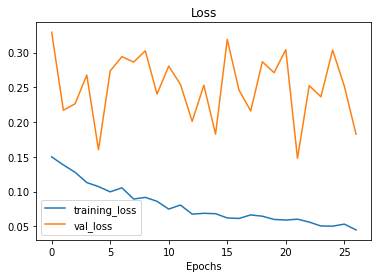

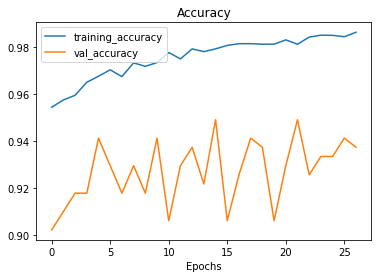

In [ ]:
plot_loss_curves(history_fine_tuned)

###Evaluating fine tuned model

In [ ]:
#evaluating fine tuned model
model_0.evaluate(test_data)

16/16 [==============================] - 2s 82ms/step - loss: 0.1794 - accuracy: 0.9460


[0.17941223084926605, 0.9459999799728394]

In [ ]:
# making predictions on test data

pred_probs = model_0.predict(test_data, verbose = 1)

16/16 [==============================] - 4s 76ms/step


In [ ]:
pred_probs.shape # 500 images with 100 classes

(500, 100)

In [ ]:
pred_probs_asOneClass = pred_probs.argmax(axis = 1) #what model predicted

In [ ]:
pred_probs_asOneClass[:2]

array([74, 15])

In [ ]:
actual_labels = [] #the actual labels

for image, one_hot_encoded_label in test_data.unbatch():
  actual_labels.append(one_hot_encoded_label.numpy().argmax())

In [ ]:
import sklearn

sklearn.metrics.confusion_matrix(y_true = actual_labels, y_pred = pred_probs_asOneClass )

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.subplots(figsize = (20,20))
sns.heatmap(sklearn.metrics.confusion_matrix(y_true = actual_labels, y_pred = pred_probs_asOneClass ), annot=True)

In [ ]:
make_confusion_matrix(y_true = actual_labels,
                                  y_pred = pred_probs_asOneClass, classes = test_data.class_names, figsize = (100,100))

####Classification Report

In [ ]:
tf.io.read_file("/content/test/air hockey/1.jpg") #returns string that contains file contents

In [ ]:
tf.io.decode_image(tf.io.read_file("/content/test/air hockey/1.jpg")) #decode the string representaion of img

In [ ]:
#make func to plot random images and see if their predictions are correct
import random, os
def random_img_plot(num_of_pics= 4, img_shape = 224):
  for i in range(num_of_pics):
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir+"/"+ class_name)) 
    filepath = test_dir + "/" + class_name + "/" + filename
    img = tf.io.read_file(filepath)
    img = tf.io.decode_image(img)
    img = tf.image.resize(img, [img_shape, img_shape])
    
    plt.figure(figsize=(20,20))
    pred_prob_one_hot = model_0.predict(tf.expand_dims(img, axis = 0))
    pred_class_name = class_names[pred_prob_one_hot.argmax()]
    plt.subplot(1, num_of_pics, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class_name: # Change the color of text based on whether prediction is right or wrong
      title_color = "g"
    else:
      title_color = "r"
    plt.title(f"actual: {class_name}\n, pred: {pred_class_name},\n prob: {pred_prob_one_hot.max():.2f}\n", c=title_color)
    plt.axis(False);



In [ ]:
random_img_plot()

####Seeing overall performance
 
 (06 notebook shows diff way for this section)

Redoing all assignments for clarity

In [ ]:
def img_predict(img_filepath, img_shape = 224):
  dirs =  img_filepath.split("/") # gets directory of where img is stored i.e class
  actual_class =  dirs[-2]
  img = tf.io.read_file(img_filepath)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  pred_prob_one_hot = model_0.predict(tf.expand_dims(img, axis = 0))
  pred_class_name = class_names[pred_prob_one_hot.argmax()]
  pred_conf = pred_prob_one_hot.max(axis = 1)
  return {"actual_class": actual_class, "pred_class_name": pred_class_name, "pred_conf":pred_conf }

In [ ]:
img_predict("/content/test/ampute football/5.jpg")["pred_conf"]

array([0.99999774], dtype=float32)

In [ ]:
import pandas as pd

filepaths = []
actual_label = []
predicted_label = []
conf = []
for filepath in test_data.list_files("/content/test/*/*.jpg",
                                     shuffle = False):
  filepaths.append(filepath.numpy().decode("utf-8"))
  returned_dict = img_predict(filepath.numpy().decode("utf-8"))
  actual_label.append(returned_dict['actual_class'])
  predicted_label.append(returned_dict['pred_class_name'])
  conf.append(returned_dict['pred_conf'])


df = pd.DataFrame({
    "file" : filepaths,
    "actual_label": actual_label,
    "predicted_label": predicted_label,
     "conf": conf
})  

df["correct"] = df["actual_label"] == df["predicted_label"]

In [ ]:
df[df["correct"]==False]

In [ ]:
def img_plot(filepath,df=df, img_shape = 224):
    img = tf.io.read_file(filepath)
    img = tf.io.decode_image(img)
    img = tf.image.resize(img, [img_shape, img_shape])
    plt.imshow(img/255.)
    plt.title(f"predicted: {df[df.file == filepath].predicted_label},\nactual: {df[df.file==filepath].actual_label},\nconf: {df[df.file==filepath].conf}")

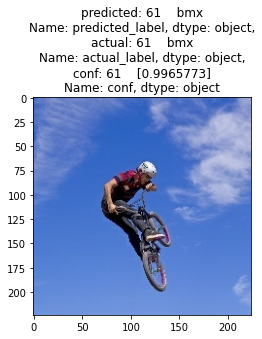

In [ ]:
img_plot("/content/test/bmx/2.jpg")

In [ ]:
#plotting all incorrect mappings

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


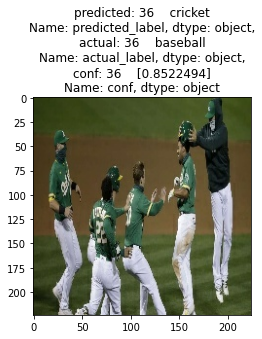

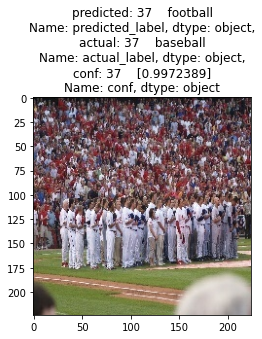

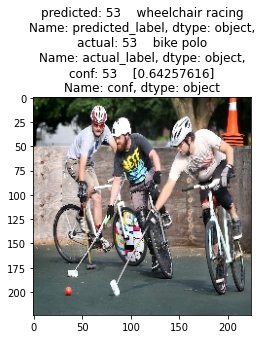

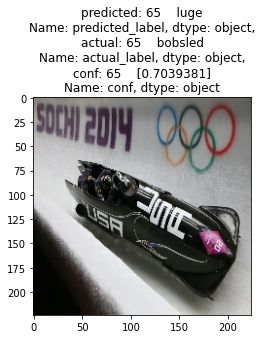

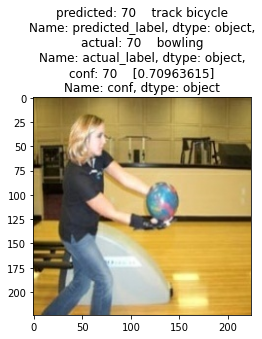

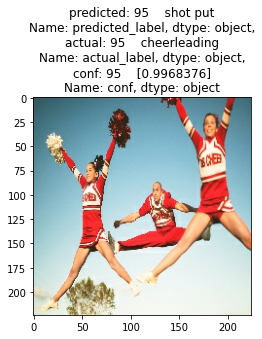

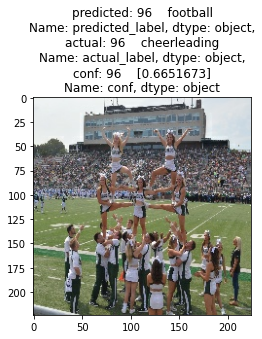

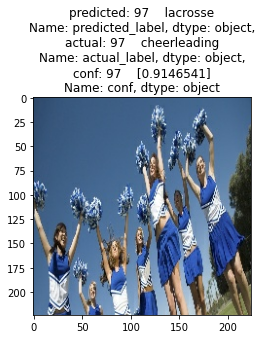

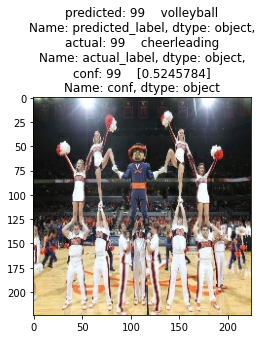

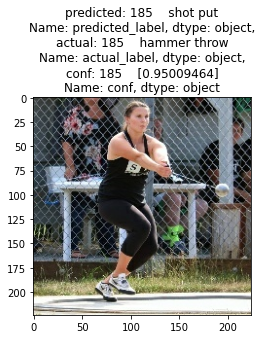

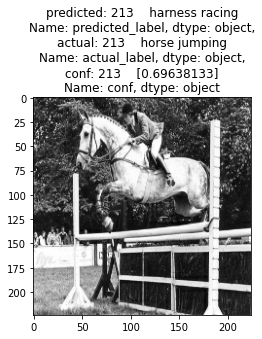

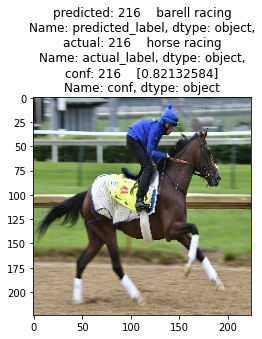

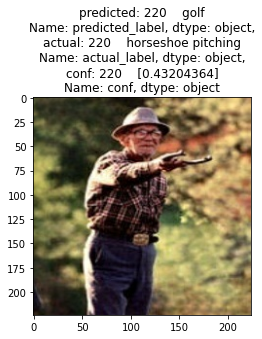

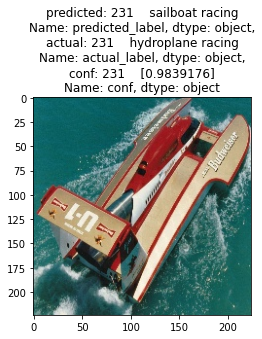

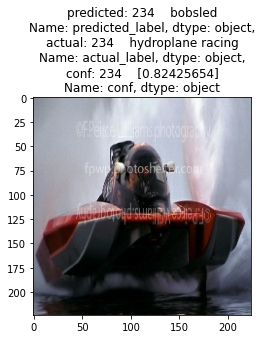

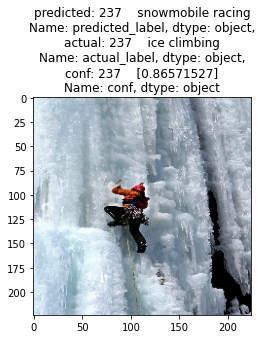

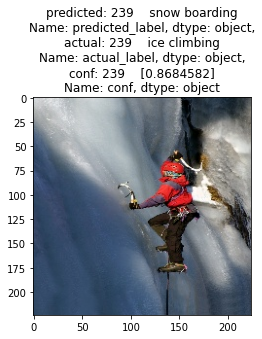

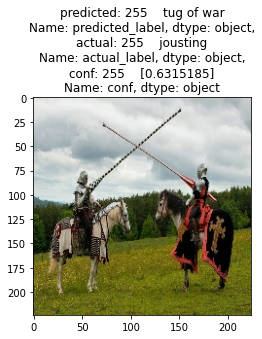

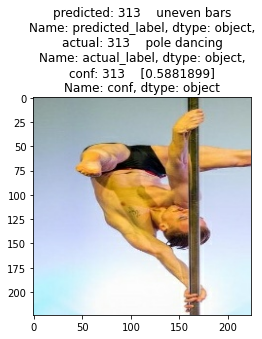

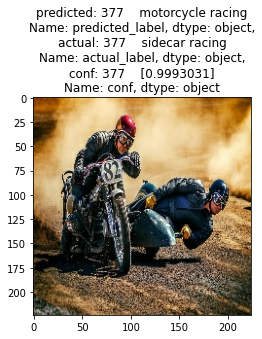

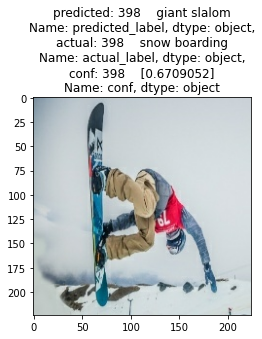

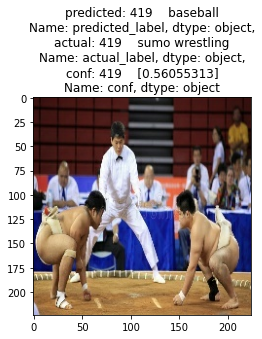

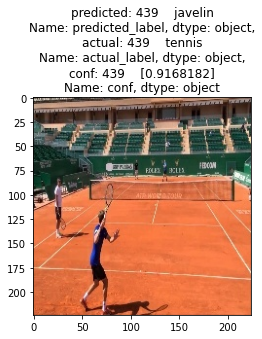

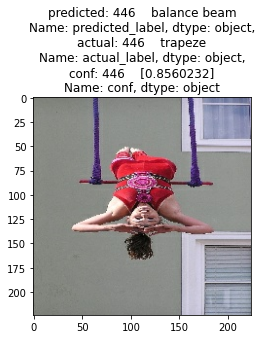

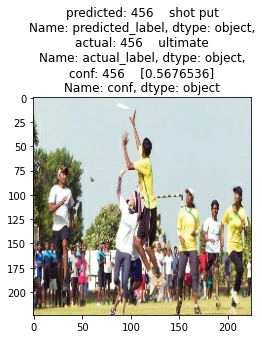

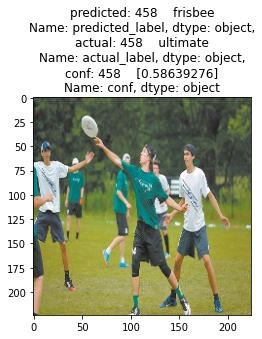

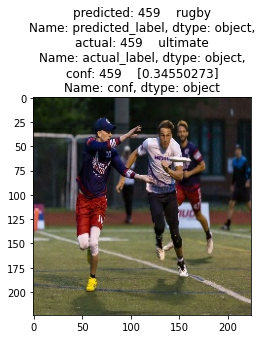

In [ ]:
for x in df[df.correct==False].file:
  plt.figure()
  img_plot(x)